# Project 5b - Population Dynamics: the Zombie apocalypse

The same ideas associated with modelling hare and lynx can be easily extended to other situations.  Here, we will model a classic zombie apocalypse.  The rules of the situation are simple:
- There are three groups: humans, hungry zombies, and fed zombies.
- The simulation should start with 100 humans, 0 hungry zombies, and 1 fed zombie
- fed zombies scratch humans, turning them into fed zombies.  This occurs in 0.008 zombie-human interactions
- fed zombies turn into hungry zombies at a rate of 0.15 (zombies per zombie) per unit time
- hungry zombies eat human brains, which removes the human from the population, but does not turn them into zombies.  They are less effective than fed zombies, so this only occurs in 0.003 of zombie-human interactions
- If a hungry zombie successfully feeds, they become a fed zombie
- hungry zombies die at a rate of 0.3 (zombies per zombie) per unit time.  

### Model development
**First, write down a system of ODEs that model this situation.  There should be a term on the right hand side corresponding to many of the above rules.  Of particular note: most rules lead to a reduction in one population and a commensurate increase in another population.  Make sure such terms appear (with opposite signs) for both populations.**

<!-- define terms with greek letters -->
$\alpha = 0.008$ is the rate at which fed zombies scratch humans, turning them into fed zombies.

$\beta = 0.15$ is the rate at which fed zombies transform into hungry zombies.

$\gamma = 0.003$ is the rate at which hungry zombies eat human brains, turning them into fed zombies.

$\delta = 0.3$ is the rate at which hungry zombies die.

The system of ODEs is:
$$
\begin{align*}
\frac{dH}{dt} &= -\alpha HZf - \gamma HZh \\
\frac{dZf}{dt} &= \alpha HZf - \beta Zf + \gamma HZh \\
\frac{dZh}{dt} &= \beta Zf - \gamma HZh - \delta Zh
\end{align*}
$$

In [1]:
import numpy as np

class ZombieApocalypse:
    def __init__(self, conversion_rate=0.008, transformation_rate=0.15, death_rate=0.3, feeding_rate=0.003, birth_rate=0.01, z_kill_rate=0, num_humans=100, num_hungry_zombies=0, num_fed_zombies=1):
        self.state = np.array([num_humans, num_hungry_zombies, num_fed_zombies], dtype=float)
        self.alpha = conversion_rate
        self.beta = transformation_rate
        self.delta = death_rate
        self.gamma = feeding_rate
        self.sigma = birth_rate
        self.omega = z_kill_rate

    def rhs(self, u):
        # RHS of the ODE
        humans, hungry_zombies, fed_zombies = u
        dhumans = self.sigma * humans - self.alpha * humans * fed_zombies - self.gamma * humans * hungry_zombies
        dhungry_zombies = self.beta*fed_zombies - self.gamma*hungry_zombies*humans - self.delta*hungry_zombies - self.omega*humans
        dfed_zombies = self.alpha*fed_zombies*humans - self.beta*fed_zombies + self.gamma*hungry_zombies * humans - self.omega*humans
        return np.array([dhumans, dhungry_zombies, dfed_zombies])
    
class Heun:
    def step(self, model, dt, state):
        # Heun's method
        k1 = model.rhs(state)
        state += dt * k1
        k2 = model.rhs(state)
        return state + dt * (k2 - k1) / 2

class Integrator:
    def __init__(self, ode, method):
        # ode is provided as one of the model classes, method is one of the integrator classes
        self.ode = ode  # store the ode
        self.method = method  # store the method
    
    def integrate(self, interval, dt, u_0):
        # interval is a list [t_0, t_end], dt is the time step, u_0 is the initial state
        t_0 = interval[0]  # initial time
        t_end = interval[1]  # final time
        times = [t_0]  # list to store the times
        states = [u_0]  # list to store the states
        t = t_0  # current time
        u = u_0  # current state
        while t < t_end:
            dt_ = min(dt, t_end - t)  # time step
            u = self.method.step(self.ode, dt_, u)  # integrate the ODE
            # if u[0] < 1: # if the number of humans is less than 1, set it to 0 (extinction of humans)
            #     u[0] = 0
            # if u[1] < 1: # if the number of hungry zombies is less than 1, set it to 0 (extinction of hungry zombies)
            #     u[1] = 0
            # if u[2] < 1: # if the number of fed zombies is less than 1, set it to 0 (extinction of fed zombies)
            #     u[2] = 0
            t = t + dt_  # update the time
            times.append(t)  # store the time
            states.append(u)  # store the state
        return np.array(times), np.array(states)  # return the times and states as numpy arrays

### Model implementation
**Implement the above model.  If it is implemented correctly, all interesting dynamics should proceed within 50 time units (are they days, hours?  I'll leave that to you to conceptualize).  Again, a second order Runge-Kutta method works fine here.**


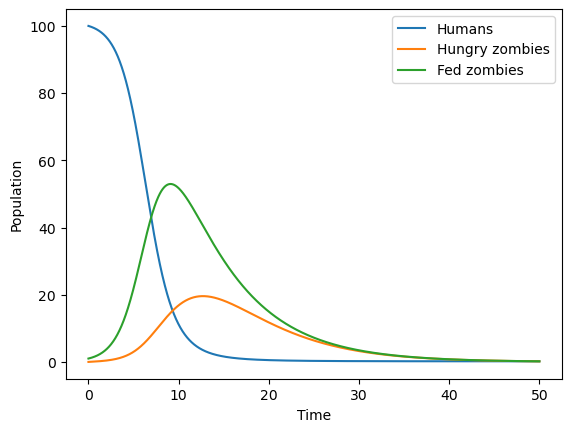

In [3]:
# Setup
conversion_rate = 0.008
transform_rate = 0.15
death_rate = 0.3
feeding_rate = 0.003
birth_rate = 0
z_kill_rate = 0

# Initial conditions
humans = 100
hungry_zombies = 0
fed_zombies = 1

# Create the model
model = ZombieApocalypse(conversion_rate, transform_rate, death_rate, feeding_rate, birth_rate, z_kill_rate, humans, hungry_zombies, fed_zombies)
# Create the integrator
integrator = Integrator(model, Heun())
# Integrate the model
time_range = [0, 50]
dt = 0.01
times, states = integrator.integrate(time_range, dt, model.state)
# Plot the results
import matplotlib.pyplot as plt
plt.plot(times, states)
plt.xlabel('Time')
plt.ylabel('Population')
plt.legend(['Humans', 'Hungry zombies', 'Fed zombies'])
plt.show()